## Inprocessing - Adversial Debiasing  -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import reset_default_graph
import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import adversial_debiasing_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

## Build up the function using race

In [ ]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]
tf.disable_v2_behavior()

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    # Reset TF graph - start new session (to avoid "Variable … already exists")
    reset_default_graph()
    sess = tf.Session()

    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    # Wrap into AIF360 
    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )

    # Instantiate & train AdversarialDebiasing
    adv = AdversarialDebiasing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        scope_name='adv',             
        debias=True,
        sess=sess
    )
    adv.fit(train_bld)

    # Predict on test split
    pred_bld = adv.predict(test_bld)
    y_test   = test_df['label'].values
    y_pred   = pred_bld.labels.ravel()

    # Compute & store metrics
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

    sess.close()

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

## refactor function

In [ ]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

In [ ]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

In [ ]:
baseline_race_agg

In [ ]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Adversial Debiasing Adult: Baseline - Race')

## Hyperparametersearch

In [ ]:
from sklearn.model_selection import ParameterGrid
import pandas as pd

# 1) Define the hyperparameter grid
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10,20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

# 2) Prepare to collect results
grid_results = []

# each hyperparam setting
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    
    sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean','std'])
    
    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean','accuracy'],
        'acc_std':    agg.loc['std', 'accuracy'],
        'f1_mean':    agg.loc['mean','f1_score'],
        'f1_std':     agg.loc['std', 'f1_score'],
        'SPD_mean':   agg.loc['mean','SPD'],
        'SPD_std':    agg.loc['std', 'SPD'],
        'DI_mean':    agg.loc['mean','DI'],
        'DI_std':     agg.loc['std', 'DI'],
        'EOD_mean':   agg.loc['mean','EOD'],
        'EOD_std':    agg.loc['std', 'EOD'],
        'AOD_mean':   agg.loc['mean','AOD'],
        'AOD_std':    agg.loc['std', 'AOD'],
    })

results_df = pd.DataFrame(grid_results)

In [ ]:
results_df

In [ ]:
# thresholds fairness
di_min, di_max        = 0.8, 1.25
spd_thresh, eod_thresh, aod_thresh = 0.1, 0.1, 0.1

# filter for configs that satisfy ALL four fairness bounds
fair_configs = results_df[
    (results_df['DI_mean']  >= di_min)  & (results_df['DI_mean']  <= di_max)   &
    (results_df['SPD_mean'].abs() <= spd_thresh)                              &
    (results_df['EOD_mean'].abs() <= eod_thresh)                              &
    (results_df['AOD_mean'].abs() <= aod_thresh)
]

# 3) Sort by (1) acc_mean ↓, (2) acc_std ↑
best = fair_configs.sort_values(
    by=['acc_mean','acc_std','DI_std'],
    ascending=[False,    True,     True]
).iloc[0]
best

- refactor best_hyperparam searcher

In [ ]:
from src.metrics import best_hyperparameter_advdeb
from sklearn.model_selection import StratifiedKFold

best_param = best_hyperparameter_advdeb(results_df)
loss_weight = best_param['adversary_loss_weight']
n_epochs    = int(best_param['num_epochs'])
batch_sz    = int(best_param['batch_size'])

folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
metrics = []
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=n_epochs,
        batch_size=batch_sz,
        adversary_loss_weight=loss_weight
    )
    m = compute_metrics(test_df, y_test, y_pred,
                        protected, privileged_value, unprivileged_value)
    metrics.append(m)
final_df = pd.DataFrame(metrics)
print(final_df.agg(['mean','std']))

In [ ]:
compare_viz_metrics_2x3(baseline_race_agg, final_df.agg(['mean','std']), 'Baseline', 'Race', 'Adversial Debiasing Adult: Baseline - Race')

--------------------------------------------------------------------------------------------------------------------------------------

## default adversial debiaser, race

In [8]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate
compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])
print(compas_race_metrics_agg)

epoch 0; iter: 0; batch classifier loss: 1.587415; batch adversarial loss: 0.688580
epoch 1; iter: 0; batch classifier loss: 0.790948; batch adversarial loss: 0.685670
epoch 2; iter: 0; batch classifier loss: 0.712041; batch adversarial loss: 0.683928
epoch 3; iter: 0; batch classifier loss: 0.626236; batch adversarial loss: 0.671881
epoch 4; iter: 0; batch classifier loss: 0.661172; batch adversarial loss: 0.654760
epoch 5; iter: 0; batch classifier loss: 0.683797; batch adversarial loss: 0.683735
epoch 6; iter: 0; batch classifier loss: 0.694554; batch adversarial loss: 0.704406
epoch 7; iter: 0; batch classifier loss: 0.751440; batch adversarial loss: 0.641066
epoch 8; iter: 0; batch classifier loss: 0.628891; batch adversarial loss: 0.700644
epoch 9; iter: 0; batch classifier loss: 0.655934; batch adversarial loss: 0.677246
epoch 10; iter: 0; batch classifier loss: 0.620623; batch adversarial loss: 0.631601
epoch 11; iter: 0; batch classifier loss: 0.633507; batch adversarial loss:

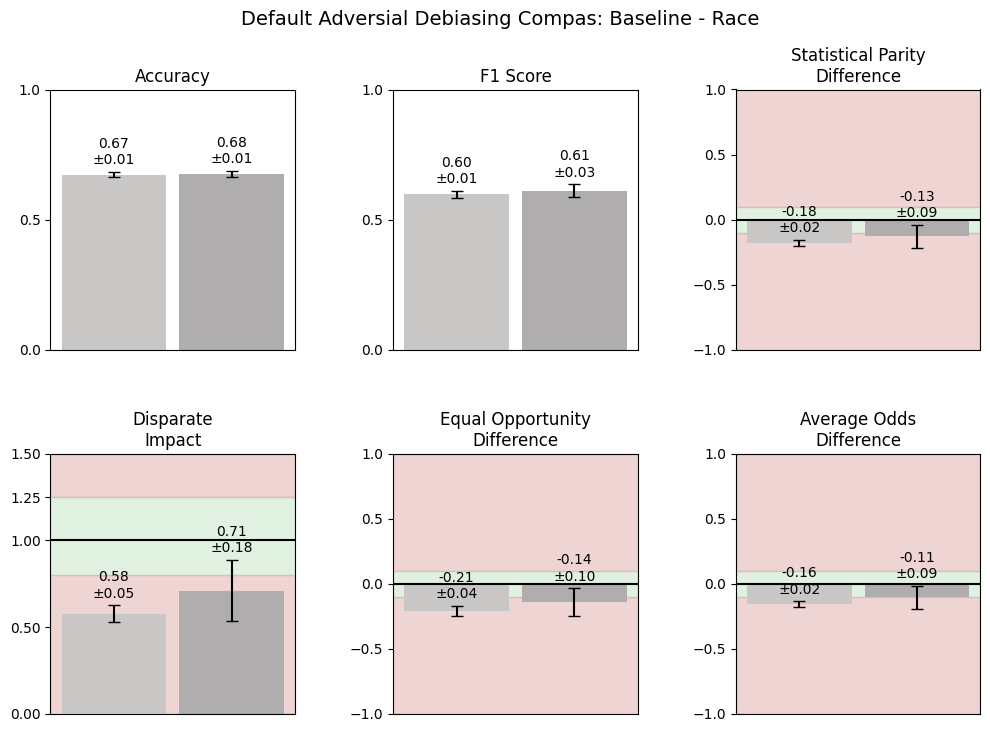

In [9]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Default Adversial Debiasing Compas: Baseline - Race')

## default adversial debiaser, sex

In [ ]:
# 1) Retrieve data
protected           = 'sex'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_sex()  
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate
compas_sex_metrics = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean','std'])
print(compas_race_metrics_agg)

In [ ]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Race', 'Default Adversial Debiasing Compas: Baseline - Sex')

## hyperparameter search adversial debiaser, race

In [4]:
import pandas as pd
from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit, StratifiedKFold
from src.metrics import best_hyperparameter_advdeb

# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Hyperparameter Search
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10, 20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

grid_results = []
# Perform hyperparameter search with 15 stratified shuffle splits
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    sss = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean', 'std'])
    
    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean', 'accuracy'],
        'acc_std':    agg.loc['std',  'accuracy'],
        'f1_mean':    agg.loc['mean', 'f1_score'],
        'f1_std':     agg.loc['std',  'f1_score'],
        'SPD_mean':   agg.loc['mean', 'SPD'],
        'SPD_std':    agg.loc['std',  'SPD'],
        'DI_mean':    agg.loc['mean', 'DI'],
        'DI_std':     agg.loc['std',  'DI'],
        'EOD_mean':   agg.loc['mean', 'EOD'],
        'EOD_std':    agg.loc['std',  'EOD'],
        'AOD_mean':   agg.loc['mean', 'AOD'],
        'AOD_std':    agg.loc['std',  'AOD'],
    })

results_df = pd.DataFrame(grid_results)

# 3) Hyperparameter Selection
best_param = best_hyperparameter_advdeb(results_df)
print(f"Best parameters: {best_param}")

# Final evaluation with StratifiedKFold
loss_weight = best_param['adversary_loss_weight']
n_epochs    = int(best_param['num_epochs'])
batch_sz    = int(best_param['batch_size'])

# 4) Run experiment, Evaluate
results = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)

for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=n_epochs,
        batch_size=batch_sz,
        adversary_loss_weight=loss_weight
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)
    
# 5) Aggregate results
compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])
print(compas_race_metrics_agg)

Testing config: {'adversary_loss_weight': 0.5, 'batch_size': 64, 'num_epochs': 10}
epoch 0; iter: 0; batch classifier loss: 0.813414; batch adversarial loss: 0.693278
epoch 1; iter: 0; batch classifier loss: 0.581723; batch adversarial loss: 0.671084
epoch 2; iter: 0; batch classifier loss: 0.784854; batch adversarial loss: 0.664088
epoch 3; iter: 0; batch classifier loss: 0.698452; batch adversarial loss: 0.660954
epoch 4; iter: 0; batch classifier loss: 0.639024; batch adversarial loss: 0.656377
epoch 5; iter: 0; batch classifier loss: 0.598140; batch adversarial loss: 0.649393
epoch 6; iter: 0; batch classifier loss: 0.641850; batch adversarial loss: 0.670275
epoch 7; iter: 0; batch classifier loss: 0.664147; batch adversarial loss: 0.682748
epoch 8; iter: 0; batch classifier loss: 0.552382; batch adversarial loss: 0.704576
epoch 9; iter: 0; batch classifier loss: 0.750145; batch adversarial loss: 0.617143
epoch 0; iter: 0; batch classifier loss: 1.324215; batch adversarial loss: 0.

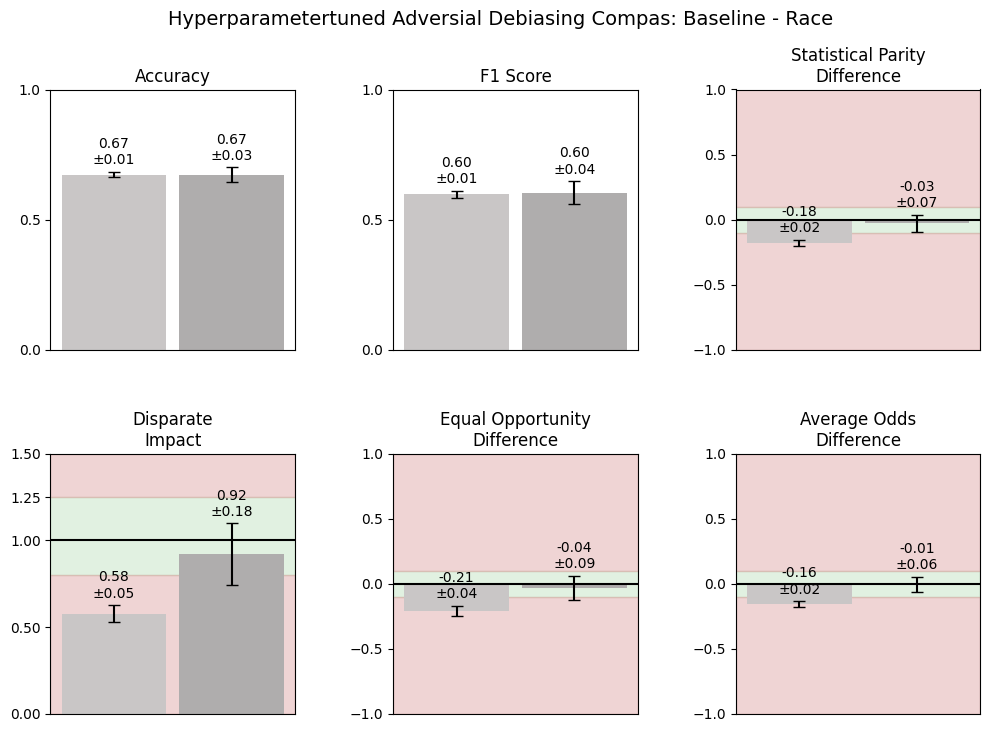

In [5]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Hyperparametertuned Adversial Debiasing Compas: Baseline - Race')

## hyperparameter search adversial debiaser, sex

In [6]:
import pandas as pd
from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit, StratifiedKFold
from src.metrics import best_hyperparameter_advdeb

# 1) Retrieve data
protected           = 'sex'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_sex()  
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Hyperparameter Search
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10, 20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

grid_results = []
# Perform hyperparameter search with 15 stratified shuffle splits
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    sss = StratifiedShuffleSplit(n_splits=15, test_size=0.3, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean', 'std'])

    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean', 'accuracy'],
        'acc_std':    agg.loc['std',  'accuracy'],
        'f1_mean':    agg.loc['mean', 'f1_score'],
        'f1_std':     agg.loc['std',  'f1_score'],
        'SPD_mean':   agg.loc['mean', 'SPD'],
        'SPD_std':    agg.loc['std',  'SPD'],
        'DI_mean':    agg.loc['mean', 'DI'],
        'DI_std':     agg.loc['std',  'DI'],
        'EOD_mean':   agg.loc['mean', 'EOD'],
        'EOD_std':    agg.loc['std',  'EOD'],
        'AOD_mean':   agg.loc['mean', 'AOD'],
        'AOD_std':    agg.loc['std',  'AOD'],
    })

results_df = pd.DataFrame(grid_results)

# 3) Hyperparameter Selection
best_param = best_hyperparameter_advdeb(results_df)
print(f"Best parameters: {best_param}")

# Final evaluation with StratifiedKFold
loss_weight = best_param['adversary_loss_weight']
n_epochs    = int(best_param['num_epochs'])
batch_sz    = int(best_param['batch_size'])

# 4) Run experiment, Evaluate
final_metrics = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)

for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=n_epochs,
        batch_size=batch_sz,
        adversary_loss_weight=loss_weight
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    final_metrics.append(m)

# 5) Aggregate results
compas_sex_metrics = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean','std'])
print(compas_sex_metrics_agg)

Testing config: {'adversary_loss_weight': 0.5, 'batch_size': 64, 'num_epochs': 10}
epoch 0; iter: 0; batch classifier loss: 2.289077; batch adversarial loss: 0.986460
epoch 1; iter: 0; batch classifier loss: 0.857807; batch adversarial loss: 0.884837
epoch 2; iter: 0; batch classifier loss: 0.860558; batch adversarial loss: 0.844656
epoch 3; iter: 0; batch classifier loss: 0.855877; batch adversarial loss: 0.734843
epoch 4; iter: 0; batch classifier loss: 0.816370; batch adversarial loss: 0.677812
epoch 5; iter: 0; batch classifier loss: 0.624935; batch adversarial loss: 0.666556
epoch 6; iter: 0; batch classifier loss: 0.671257; batch adversarial loss: 0.620969
epoch 7; iter: 0; batch classifier loss: 0.759504; batch adversarial loss: 0.613912
epoch 8; iter: 0; batch classifier loss: 0.610176; batch adversarial loss: 0.570239
epoch 9; iter: 0; batch classifier loss: 0.603746; batch adversarial loss: 0.513164
epoch 0; iter: 0; batch classifier loss: 1.444978; batch adversarial loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 2.243007; batch adversarial loss: 0.749570
epoch 1; iter: 0; batch classifier loss: 0.731703; batch adversarial loss: 0.694031
epoch 2; iter: 0; batch classifier loss: 0.614887; batch adversarial loss: 0.674901
epoch 3; iter: 0; batch classifier loss: 0.819945; batch adversarial loss: 0.647848
epoch 4; iter: 0; batch classifier loss: 0.649542; batch adversarial loss: 0.630598
epoch 5; iter: 0; batch classifier loss: 0.675146; batch adversarial loss: 0.623833
epoch 6; iter: 0; batch classifier loss: 0.610596; batch adversarial loss: 0.581037
epoch 7; iter: 0; batch classifier loss: 0.620443; batch adversarial loss: 0.613572
epoch 8; iter: 0; batch classifier loss: 0.638349; batch adversarial loss: 0.562896
epoch 9; iter: 0; batch classifier loss: 0.670642; batch adversarial loss: 0.562102
epoch 0; iter: 0; batch classifier loss: 2.196578; batch adversarial loss: 1.437384
epoch 1; iter: 0; batch classifier loss: 1.815795; batch adversarial loss: 1

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 3.372158; batch adversarial loss: 1.621349
epoch 1; iter: 0; batch classifier loss: 1.980920; batch adversarial loss: 1.406153
epoch 2; iter: 0; batch classifier loss: 1.174090; batch adversarial loss: 1.392914
epoch 3; iter: 0; batch classifier loss: 1.189895; batch adversarial loss: 1.400921
epoch 4; iter: 0; batch classifier loss: 1.237619; batch adversarial loss: 1.337748
epoch 5; iter: 0; batch classifier loss: 1.319190; batch adversarial loss: 1.333442
epoch 6; iter: 0; batch classifier loss: 1.190272; batch adversarial loss: 1.259774
epoch 7; iter: 0; batch classifier loss: 1.256803; batch adversarial loss: 1.219725
epoch 8; iter: 0; batch classifier loss: 1.318954; batch adversarial loss: 1.144630
epoch 9; iter: 0; batch classifier loss: 1.535497; batch adversarial loss: 1.104709
epoch 0; iter: 0; batch classifier loss: 0.877246; batch adversarial loss: 0.678652
epoch 1; iter: 0; batch classifier loss: 0.760041; batch adversarial loss: 0

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.947500; batch adversarial loss: 0.739542
epoch 1; iter: 0; batch classifier loss: 1.483468; batch adversarial loss: 0.842246
epoch 2; iter: 0; batch classifier loss: 1.028082; batch adversarial loss: 0.803979
epoch 3; iter: 0; batch classifier loss: 0.836971; batch adversarial loss: 0.804215
epoch 4; iter: 0; batch classifier loss: 0.815249; batch adversarial loss: 0.746230
epoch 5; iter: 0; batch classifier loss: 0.700106; batch adversarial loss: 0.722362
epoch 6; iter: 0; batch classifier loss: 0.687550; batch adversarial loss: 0.685808
epoch 7; iter: 0; batch classifier loss: 0.606513; batch adversarial loss: 0.655698
epoch 8; iter: 0; batch classifier loss: 0.634629; batch adversarial loss: 0.641237
epoch 9; iter: 0; batch classifier loss: 0.639665; batch adversarial loss: 0.628211
epoch 0; iter: 0; batch classifier loss: 1.328904; batch adversarial loss: 0.705009
epoch 1; iter: 0; batch classifier loss: 0.684985; batch adversarial loss: 0

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 1.194828; batch adversarial loss: 0.798124
epoch 1; iter: 0; batch classifier loss: 0.960717; batch adversarial loss: 0.793080
epoch 2; iter: 0; batch classifier loss: 0.622237; batch adversarial loss: 0.729888
epoch 3; iter: 0; batch classifier loss: 0.720702; batch adversarial loss: 0.708220
epoch 4; iter: 0; batch classifier loss: 0.670856; batch adversarial loss: 0.700610
epoch 5; iter: 0; batch classifier loss: 0.593266; batch adversarial loss: 0.658621
epoch 6; iter: 0; batch classifier loss: 0.703014; batch adversarial loss: 0.646127
epoch 7; iter: 0; batch classifier loss: 0.619010; batch adversarial loss: 0.627511
epoch 8; iter: 0; batch classifier loss: 0.662469; batch adversarial loss: 0.618022
epoch 9; iter: 0; batch classifier loss: 0.599631; batch adversarial loss: 0.610331
epoch 10; iter: 0; batch classifier loss: 0.600703; batch adversarial loss: 0.602131
epoch 11; iter: 0; batch classifier loss: 0.589133; batch adversarial loss:

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.893271; batch adversarial loss: 0.610291
epoch 1; iter: 0; batch classifier loss: 1.109091; batch adversarial loss: 0.678413
epoch 2; iter: 0; batch classifier loss: 0.744281; batch adversarial loss: 0.651450
epoch 3; iter: 0; batch classifier loss: 0.850039; batch adversarial loss: 0.686720
epoch 4; iter: 0; batch classifier loss: 0.791940; batch adversarial loss: 0.639052
epoch 5; iter: 0; batch classifier loss: 0.961690; batch adversarial loss: 0.666153
epoch 6; iter: 0; batch classifier loss: 0.808145; batch adversarial loss: 0.622068
epoch 7; iter: 0; batch classifier loss: 0.861350; batch adversarial loss: 0.630076
epoch 8; iter: 0; batch classifier loss: 0.749584; batch adversarial loss: 0.616680
epoch 9; iter: 0; batch classifier loss: 0.824135; batch adversarial loss: 0.631438
epoch 10; iter: 0; batch classifier loss: 0.740575; batch adversarial loss: 0.618812
epoch 11; iter: 0; batch classifier loss: 0.814117; batch adversarial loss:

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 2.152488; batch adversarial loss: 0.693182
epoch 1; iter: 0; batch classifier loss: 1.074749; batch adversarial loss: 0.659736
epoch 2; iter: 0; batch classifier loss: 0.799011; batch adversarial loss: 0.645703
epoch 3; iter: 0; batch classifier loss: 0.711886; batch adversarial loss: 0.632652
epoch 4; iter: 0; batch classifier loss: 0.641020; batch adversarial loss: 0.638248
epoch 5; iter: 0; batch classifier loss: 0.789772; batch adversarial loss: 0.592300
epoch 6; iter: 0; batch classifier loss: 0.825751; batch adversarial loss: 0.588048
epoch 7; iter: 0; batch classifier loss: 0.675763; batch adversarial loss: 0.556167
epoch 8; iter: 0; batch classifier loss: 0.576089; batch adversarial loss: 0.609001
epoch 9; iter: 0; batch classifier loss: 0.671877; batch adversarial loss: 0.499569
epoch 0; iter: 0; batch classifier loss: 1.216841; batch adversarial loss: 0.693270
epoch 1; iter: 0; batch classifier loss: 1.016652; batch adversarial loss: 0

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 1.455076; batch adversarial loss: 0.744543
epoch 1; iter: 0; batch classifier loss: 1.501536; batch adversarial loss: 0.928495
epoch 2; iter: 0; batch classifier loss: 1.352545; batch adversarial loss: 0.922652
epoch 3; iter: 0; batch classifier loss: 1.176223; batch adversarial loss: 0.900838
epoch 4; iter: 0; batch classifier loss: 0.998656; batch adversarial loss: 0.825026
epoch 5; iter: 0; batch classifier loss: 1.069701; batch adversarial loss: 0.787921
epoch 6; iter: 0; batch classifier loss: 0.908530; batch adversarial loss: 0.741096
epoch 7; iter: 0; batch classifier loss: 1.069675; batch adversarial loss: 0.735141
epoch 8; iter: 0; batch classifier loss: 1.017815; batch adversarial loss: 0.678323
epoch 9; iter: 0; batch classifier loss: 0.908997; batch adversarial loss: 0.633446
epoch 0; iter: 0; batch classifier loss: 1.069041; batch adversarial loss: 1.033833
epoch 1; iter: 0; batch classifier loss: 1.833208; batch adversarial loss: 1

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 1.126519; batch adversarial loss: 0.934283
epoch 1; iter: 0; batch classifier loss: 1.377797; batch adversarial loss: 0.902399
epoch 2; iter: 0; batch classifier loss: 0.858771; batch adversarial loss: 0.822741
epoch 3; iter: 0; batch classifier loss: 0.874578; batch adversarial loss: 0.805835
epoch 4; iter: 0; batch classifier loss: 1.117344; batch adversarial loss: 0.814100
epoch 5; iter: 0; batch classifier loss: 1.167475; batch adversarial loss: 0.792949
epoch 6; iter: 0; batch classifier loss: 1.148506; batch adversarial loss: 0.743776
epoch 7; iter: 0; batch classifier loss: 1.102387; batch adversarial loss: 0.702517
epoch 8; iter: 0; batch classifier loss: 0.942910; batch adversarial loss: 0.650831
epoch 9; iter: 0; batch classifier loss: 0.841476; batch adversarial loss: 0.634496
epoch 0; iter: 0; batch classifier loss: 2.097364; batch adversarial loss: 0.695153
epoch 1; iter: 0; batch classifier loss: 0.851682; batch adversarial loss: 0

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 2.291462; batch adversarial loss: 0.692475
epoch 1; iter: 0; batch classifier loss: 0.863774; batch adversarial loss: 0.664539
epoch 2; iter: 0; batch classifier loss: 0.684898; batch adversarial loss: 0.673111
epoch 3; iter: 0; batch classifier loss: 0.918174; batch adversarial loss: 0.645579
epoch 4; iter: 0; batch classifier loss: 0.733504; batch adversarial loss: 0.665652
epoch 5; iter: 0; batch classifier loss: 0.694570; batch adversarial loss: 0.654348
epoch 6; iter: 0; batch classifier loss: 0.808383; batch adversarial loss: 0.644277
epoch 7; iter: 0; batch classifier loss: 0.880191; batch adversarial loss: 0.655689
epoch 8; iter: 0; batch classifier loss: 0.842874; batch adversarial loss: 0.636710
epoch 9; iter: 0; batch classifier loss: 0.719750; batch adversarial loss: 0.600716
epoch 10; iter: 0; batch classifier loss: 0.772151; batch adversarial loss: 0.590407
epoch 11; iter: 0; batch classifier loss: 0.678000; batch adversarial loss:

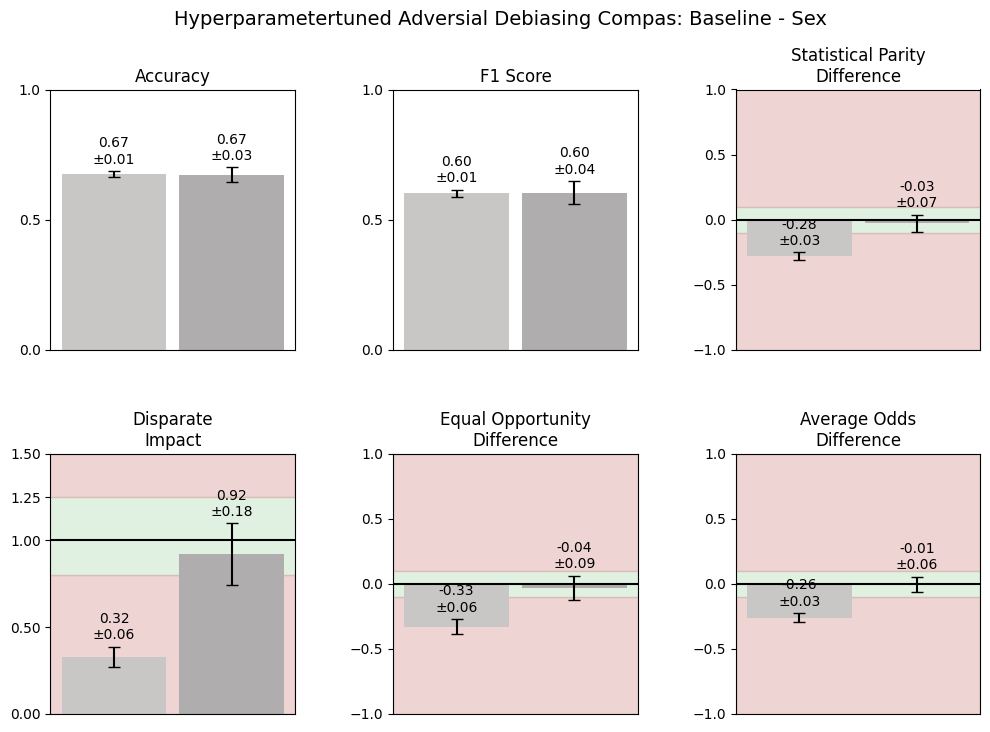

In [7]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Race', 'Hyperparametertuned Adversial Debiasing Compas: Baseline - Sex')